In this notebook, we will fine-tune gpt-2 model for adapting it to customer conversation sentiment classification.

If you didn't install the required packages before, you can with the commented out lines below. Otherwise, you will get errors at the first import.

In [1]:
#!pip install torch numpy transformers datasets tiktoken wandb tqdm matplotlib seaborn scipy scikit-learn
#!pip install accelerate
#!pip install transformers torch -U

In [2]:
import pickle
import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from models.evaluate_fine_tuned import evaluate_on_test
from sklearn.metrics import confusion_matrix

/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenized_datasets = datasets.load_from_disk(f"../data/final/train-val.hf")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 776
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 194
    })
})

In [4]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)
model

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"]
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,2.233900
1000,0.999300
1500,0.869700
2000,0.749200
2500,0.560900
3000,0.588300
3500,0.377900


TrainOutput(global_step=3880, training_loss=0.8646149428849368, metrics={'train_runtime': 589.1376, 'train_samples_per_second': 6.586, 'train_steps_per_second': 6.586, 'total_flos': 2027681092730880.0, 'train_loss': 0.8646149428849368, 'epoch': 5.0})

In [6]:
test_path = "../data/final/test.csv"
df_test = pd.read_csv(test_path)

preds, labels = evaluate_on_test(model, df_test)

Prediction: neutral - Label: negative
Prediction: neutral - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: negative - Label: negative
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: neutral
Prediction: neutral - Label: positive
Prediction: neutral - Label: positive
Prediction: neutral - Label: positive
Prediction: neutral - Label: positive
Prediction: neutral - Label: positive
Prediction: neutral - Label: positive
Prediction: ne

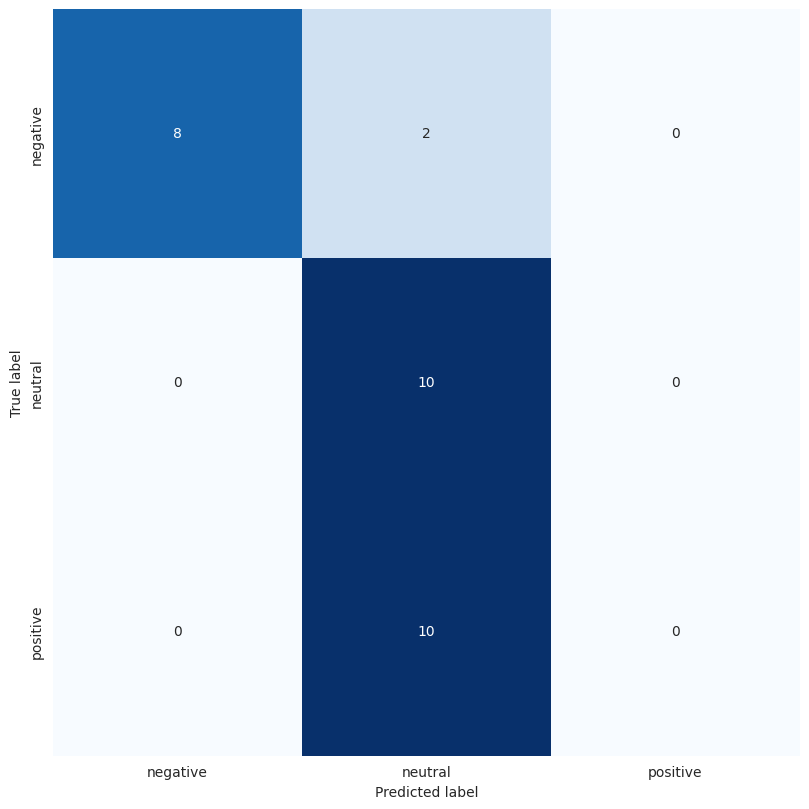

In [7]:
classes = ["negative", "neutral", "positive"]
cm = confusion_matrix(labels, preds, labels=classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False, xticklabels=classes, yticklabels=classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(labels, preds, target_names=classes))

              precision    recall  f1-score   support

    negative       1.00      0.80      0.89        10
     neutral       0.45      1.00      0.62        10
    positive       0.00      0.00      0.00        10

    accuracy                           0.60        30
   macro avg       0.48      0.60      0.50        30
weighted avg       0.48      0.60      0.50        30



/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eren/anaconda3/envs/DI725_assignment1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [9]:
model_path = '../models/4_gpt2_sentiment_model.pkl'
with open(model_path,'wb') as f:
    pickle.dump(model, f)